In [1]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from numpy import linalg as LA

#import sys
#sys.path.append("..")

from utils import *
from dictionary import *
from vis import *

import ipdb

In [5]:
# SR_MFSR.py
from skimage import io as skio 
from skimage import color as skco
from skimage import transform


class MFSR():
    def __init__(self, img, psize=6, upscale=3, conscale=3, beta=0.1, dtype=1, 
                 overlap=5, alpha1=0.0001, alpha2=0.001, ref_num=10, rdtype=11):
        self.W = img.shape[0]
        self.H = img.shape[1]
        self.uW = self.W * upscale
        self.uH = self.H * upscale
        self.cW = self.W * conscale
        self.cH = self.H * conscale
        self.w = psize
        self.h = psize
        self.uw = psize * upscale
        self.uh = psize * upscale
        
        self.img_L_rgb = img
        
        self.psize = psize
        self.upscale = upscale
        self.conscale = conscale
        self.beta = beta
        self.overlap = overlap
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        self.ref_num = ref_num
        
        self.dtype = dtype
        self.rdtype = rdtype

    
    def update_dic(self, dtype):
        self.dic = Dictionary(upscale=self.upscale, dtype=dtype, psize=6)
        # self.dic_r = Dictionary(upscale=upscale, dtype=60, psize=psize)
        
        self.DL = self.dic.L['data'].transpose()
        self.DH = self.dic.H['data'].transpose()
        self.norm_L = np.sqrt(np.sum(self.DL**2, axis = 0))
        self.DL /= self.norm_L  
        self.DH /= self.norm_L
        
    def super_resolution2(self):
        self.img_L = self.img_L_rgb / 255.0
        self.img_H_y = np.zeros((self.uW, self.uH))
        
        self.update_dic(self.dtype)
        self.sample_patches()
        self.sparse_rep()
        self.reconstruct1()
        
        self.update_dic(self.rdtype)
        self.sample_patches()
        self.refine()
        self.reconstruct2()
        
        
        self.unify()
        self.img_H_rgb = self.img_H_y * 255.0
        
        
        
    def super_resolution(self):        
        img_L_ycbcr = skco.rgb2ycbcr(self.img_L_rgb)
        img_L_y = img_L_ycbcr[:, :, 0]
        img_L_cb = img_L_ycbcr[:, :, 1]
        img_L_cr = img_L_ycbcr[:, :, 2]
        self.img_L = img_L_y / 255.0
        
        
        self.img_H_y = np.zeros((self.uW, self.uH))
        
        self.update_dic(self.dtype)
        self.sample_patches()
        self.sparse_rep()
        self.reconstruct1()
        
        self.update_dic(self.rdtype)
        self.sample_patches()
        self.refine()
        self.reconstruct2()
        # self.back_projection()
        # self.procedure.append([self.img_H.copy(), 'After MFSR'])
            
        img_H_cb = transform.resize(img_L_cb,(self.cW, self.cH),order=1)
        img_H_cr = transform.resize(img_L_cr,(self.cW, self.cH),order=1)
        
        img_H_ycbcr = np.zeros((self.cW, self.cH, 3))
        img_H_ycbcr[:, :, 0] = self.img_H_y * 255.0
        img_H_ycbcr[:, :, 1] = img_H_cb
        img_H_ycbcr[:, :, 2] = img_H_cr
        
        self.img_H_rgb = skco.ycbcr2rgb(img_H_ycbcr)
        
        # self.unify()
        
        
    def unify(self):
        self.img_H_y[self.img_H_y < 0] = 0
        self.img_H_y[self.img_H_y > 1] = 1
        
    
    
    
    def sparse_rep(self):
        self.img_H = np.zeros((self.uW, self.uH))
        self.img_cnt = np.zeros((self.uW, self.uH))
        
        uw = self.w * self.upscale
        uh = self.h * self.upscale
        u = self.upscale
        
        #===========================================================
        #  set the lasso optimizer
        from sklearn import linear_model
        clf = linear_model.Lasso(alpha=self.alpha1, max_iter=50, fit_intercept=False)
           
        count = 0
        for patch in self.patches:
            lt_x, lt_y = patch['pos']
            roi_L = patch['data'].copy()
            # roi_L = self.img_L[lt_x:lt_x + self.w, lt_y:lt_y + self.h]                                            
            y = roi_L.reshape(-1, 1)
            
            #===== norm =====
            mean_y = np.mean(y)
            y -= mean_y
            norm_y = np.sqrt(np.sum(y**2))
            if norm_y >0 : y /= norm_y
            
            #===========================================================
            #  lasso optimizer
            clf.fit(self.DL, y)
            alpha = np.array(clf.coef_).reshape(-1, 1)
            
            count += 1
            loss = LA.norm(y - np.dot(self.DL, alpha), 2) + self.alpha1 * LA.norm(alpha, 1)
            if count % 1000 == 0:
                print("patch count: ", count, "    loss: ", loss)        
            patch['rep'] = alpha

    
    def refine(self):
        #===========================================================
        #  set the lasso optimizer
        from sklearn import linear_model
        clf = linear_model.Lasso(alpha=self.alpha2, max_iter=10, fit_intercept=False)
        
        scales = [7/6, 8/6, 9/6, 10/6, 11/6, 12/6]
        sref_num = [0, 0, 0, 0, 0, 6]
        sref_num = [1, 1, 1, 1, 0, 2]
        N_scale = len(scales)
        
        for i in range(N_scale):
            scale, ref_num = scales[i], sref_num[i]
            DH = upscale_dic(self.dic.L, upscale = scale)['data'].transpose()
            sw, sh = int(scale * 6), int(scale * 6)
            DH /= self.norm_L
            print("Scale " , sh , " started ")
            
            for patch in self.patches:
                
                roi_L = patch['data'].copy()
                
                mean_y = np.mean(roi_L)
                roi_L -= mean_y
                norm_y = np.sqrt(np.sum(roi_L**2))
                if norm_y > 0 : roi_L /= norm_y
                
                
                for iter_ in range(ref_num):
                    # ipdb.set_trace()
                    alpha = patch['rep']
                    rep_H = np.dot(DH, alpha).reshape(sw, sh)
                    rep_L = transform.resize(rep_H, (6, 6), order=1)

                    res_y = roi_L.reshape(-1, 1) - rep_L.reshape(-1, 1)

                    clf.fit(self.DL, res_y)
                    alpha_res = np.array(clf.coef_).reshape(-1, 1)

                    patch['rep'] += alpha_res
                        
            
            
    def reconstruct1(self):
        img_H = np.zeros((self.cW, self.cH))
        img_cnt = np.zeros((self.cW, self.cH))
        
        uw = self.w * self.conscale
        uh = self.h * self.conscale
        u = self.conscale
        DH = upscale_dic(self.dic.L, upscale = u)['data'].transpose()
        DH /= self.norm_L
        
        
        for patch in self.patches:
            lt_x, lt_y = patch['pos']
            y = patch['data'].reshape(-1, 1)
            mean_y = np.mean(y)
            y -= mean_y
            norm_y = np.sqrt(np.sum(y**2))
            if norm_y > 0 : y /= norm_y
            
            alpha = patch['rep']
            roi_H_SR = np.dot(DH, alpha).reshape(uw, uh)
            if norm_y > 0 : roi_H_SR *= norm_y
            roi_H_SR += mean_y
            loss = LA.norm(y - np.dot(self.DL, alpha), 2) + self.alpha1 * LA.norm(alpha, 1)
            # loss = 1
            weight = (1.0 / (loss + 1e-4))
            
        
            img_H[lt_x * u: lt_x * u + uw, lt_y * u: lt_y * u + uh] += roi_H_SR * weight
            img_cnt[lt_x * u: lt_x * u + uw, lt_y * u: lt_y * u + uh] += (weight)
            
            
                
        mask = (img_cnt == 0)
        mask_bicubic = mask * transform.resize(self.img_L, (self.cW, self.cH), order=1)
        img_cnt += mask
        img_H += mask_bicubic
        img_H = img_H / img_cnt
        self.img_L -= transform.resize(img_H, (self.W, self.H), order=1)
        
        self.img_H_y += img_H
        
        # ipdb.set_trace()
        
    def reconstruct2(self):
        img_H = np.zeros((self.cW, self.cH))
        img_cnt = np.zeros((self.cW, self.cH))
        
        uw = self.w * self.conscale
        uh = self.h * self.conscale
        u = self.conscale
        DH = upscale_dic(self.dic.L, upscale = u)['data'].transpose()
        # ipdb.set_trace()
        # filter_dic(self.dic.L, DH)
        DH /= self.norm_L
        
        
        
        for patch in self.patches:
            lt_x, lt_y = patch['pos']
            y = patch['data'].reshape(-1, 1)
            mean_y = np.mean(y)
            y -= mean_y
            norm_y = np.sqrt(np.sum(y**2))
            if norm_y > 0 : y /= norm_y
            
            alpha = patch['rep']
            roi_H_SR = np.dot(DH, alpha).reshape(uw, uh)
            if norm_y > 0 : roi_H_SR *= norm_y
            roi_H_SR += mean_y
            loss = LA.norm(y - np.dot(self.DL, alpha), 2) + self.alpha1 * LA.norm(alpha, 1)
            # loss = 1
            weight = (1.0 / (loss + 1e-4))
            
        
            img_H[lt_x * u: lt_x * u + uw, lt_y * u: lt_y * u + uh] += roi_H_SR * weight
            img_cnt[lt_x * u: lt_x * u + uw, lt_y * u: lt_y * u + uh] += (weight)
            
            
                
        mask = (img_cnt == 0)
        mask_bicubic = mask * transform.resize(self.img_L, (self.cW, self.cH), order=1)
        img_cnt += mask
        img_H += mask_bicubic
        img_H = img_H / img_cnt
        self.img_L -= transform.resize(img_H, (self.W, self.H), order=1)
        
        self.img_H_y += img_H

    
        
    def sample_patches(self):
        self.patches = []
        for i in range(0, self.W, self.psize - self.overlap):
            for j in range(0, self.H, self.psize - self.overlap):
                if i + self.w >= self.W or j + self.h >= self.H: continue   
                tmp = {}
                tmp['data'] = self.img_L[i:i+self.w, j:j+self.h]
                tmp['pos'] = (i, j)
                tmp['rep'] = np.zeros((self.dic.size, 1))
                self.patches.append(tmp)
        
        
img_id = '014'
conscale = 2
img_L_rgb = skio.imread(img_route(img_id = img_id, scale=conscale))
# vis_img(img_L_rgb)
MFSR_1 = MFSR(img_L_rgb, rdtype=11, dtype=6, overlap=4, psize=6, alpha2=0.0001, 
              conscale=conscale, upscale=2)
MFSR_1.super_resolution()
quick_eval(MFSR_1.img_H_rgb, img_id=img_id, scale=conscale)

Set14/image_SRF_2/img_014_SRF_2_LR.png
6
size of the dic is : 334


/Users/eulring/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


patch count:  1000     loss:  0.018353399060567772
patch count:  2000     loss:  0.01924593002403399
patch count:  3000     loss:  0.02005850625577657
patch count:  4000     loss:  0.01658304057765356
patch count:  5000     loss:  0.01626222802750216
patch count:  6000     loss:  0.01874653347987789
patch count:  7000     loss:  0.018579236334943808
patch count:  8000     loss:  0.01790886171220688
patch count:  9000     loss:  0.018699278866186334
patch count:  10000     loss:  0.01924145028342838
patch count:  11000     loss:  0.017996828710193803
patch count:  12000     loss:  0.018500613685122392
patch count:  13000     loss:  0.01886560363994363


/Users/eulring/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/eulring/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


11
size of the dic is : 162
Scale  7  started 
Scale  8  started 
Scale  9  started 
Scale  10  started 
Scale  11  started 
Scale  12  started 
Set14/image_SRF_2/img_014_SRF_2_bicubic.png
Set14/image_SRF_2/img_014_SRF_2_HR.png
PSNR/SSIM for Bicubic Interpolation: %f dB 30.687698514588128 0.9162199985640664
PSNR/SSIM for Sparse Representation Recovery: %f dB 31.59362871360708 0.9334076780789834


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Set14/image_SRF_2/img_014_SRF_2_bicubic.png
Set14/image_SRF_2/img_014_SRF_2_HR.png
Set14/image_SRF_2/img_014_SRF_2_nearest.png
Set14/image_SRF_2/img_014_SRF_2_glasner.png


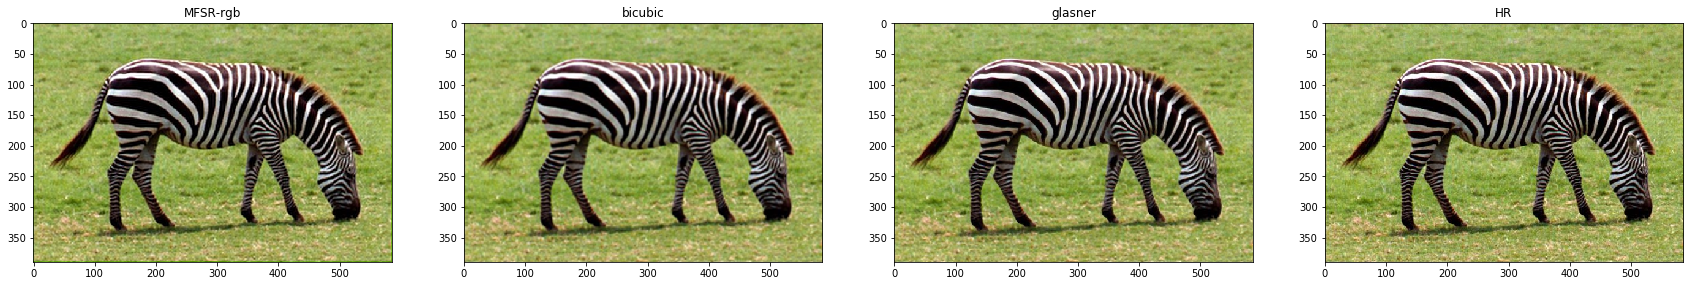

Set14/image_SRF_2/img_014_SRF_2_bicubic.png
Set14/image_SRF_2/img_014_SRF_2_HR.png
PSNR/SSIM for Bicubic Interpolation: %f dB 30.687698514588128 0.9162199985640664
PSNR/SSIM for Sparse Representation Recovery: %f dB 31.31697233414521 0.9302080335561967
Set14/image_SRF_2/img_014_SRF_2_bicubic.png
Set14/image_SRF_2/img_014_SRF_2_HR.png
PSNR/SSIM for Bicubic Interpolation: %f dB 30.687698514588128 0.9162199985640664
PSNR/SSIM for Sparse Representation Recovery: %f dB 31.12952759737357 0.9239475750951787
Set14/image_SRF_2/img_014_SRF_2_bicubic.png
Set14/image_SRF_2/img_014_SRF_2_HR.png
PSNR/SSIM for Bicubic Interpolation: %f dB 30.687698514588128 0.9162199985640664
PSNR/SSIM for Sparse Representation Recovery: %f dB 27.376761520900807 0.8762897903104334
(390, 586, 3)


In [4]:
img_bicubic = skio.imread(img_route(method = 'bicubic', img_id = img_id, ))
img_HR = skio.imread(img_route(method = 'HR', img_id = img_id))
img_NN = skio.imread(img_route(method = 'nearest', img_id = img_id))
img_glasner = skio.imread(img_route(method = 'glasner', img_id = img_id))

imgs = []
# imgs.append((MFSR_1.img_H, 'MFSR-y'))
imgs.append((MFSR_1.img_H_rgb, 'MFSR-rgb'))
imgs.append((img_bicubic, 'bicubic'))
imgs.append((img_glasner, 'glasner'))
imgs.append((img_HR, 'HR'))
vis_imgs(imgs, v_max=255.0)


quick_eval(MFSR_1.img_H_rgb, img_id)
quick_eval(img_glasner, img_id)
quick_eval(img_NN, img_id)


print(img_HR.shape)